In [1]:
dirtrain = './grape_leaf_disease_detection/image_data/train/'
dirtest = './grape_leaf_disease_detection/image_data/test/'

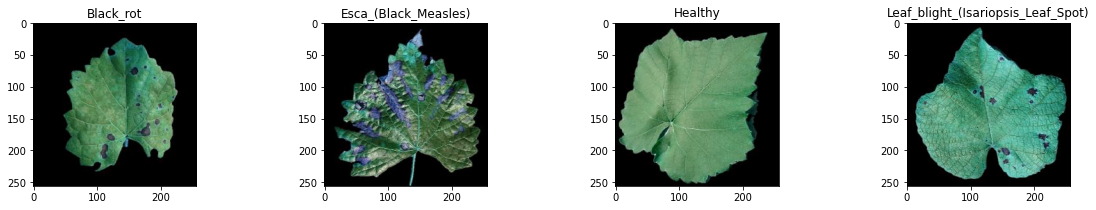

Image size: 256x256x3


In [2]:
from toolkit import *

_, IMG_ROW, IMG_COL, CNUM = get_metadata(dirtrain)
print("Image size: %dx%dx%d" % (IMG_ROW, IMG_COL, CNUM))

In [3]:
NEW_SIZE = 128
x_train, y_train = load_and_resize(dirtrain, new_size=NEW_SIZE)
x_test, y_test = load_and_resize(dirtest, new_size=NEW_SIZE)

print(x_train.shape)

x_train = x_train/255
x_test = x_test/255

print("All complete")

Load images from Black_rot ... 
Load images from Esca_(Black_Measles) ... 
Load images from Healthy ... 
Load images from Leaf_blight_(Isariopsis_Leaf_Spot) ... 
Load images from Black_rot ... 
Load images from Esca_(Black_Measles) ... 
Load images from Healthy ... 
Load images from Leaf_blight_(Isariopsis_Leaf_Spot) ... 
(3209, 128, 128, 3)
All complete


In [4]:
import pickle, gzip, os

pkl_file = '../data.pkl.gz'
if os.path.isfile(pkl_file):
    print("File exists, loading ...")
    with gzip.open(pkl_file, 'r') as f:
        dicts = pickle.load(f)
        x_train = dicts['x_train']
        x_test = dicts['x_test']
        y_train = dicts['y_train']
        y_test = dicts['y_test']
else:
    print("Saving ...")
    with gzip.open(pkl_file, 'wb') as f:
        pickle.dump({
            'x_train': x_train,
            'x_test': x_test,
            'y_train': y_train,
            'y_test': y_test
        }, f)    

File exists, loading ...


Train image size
(3209, 128, 128, 3)
Test image size
(880, 128, 128, 3)


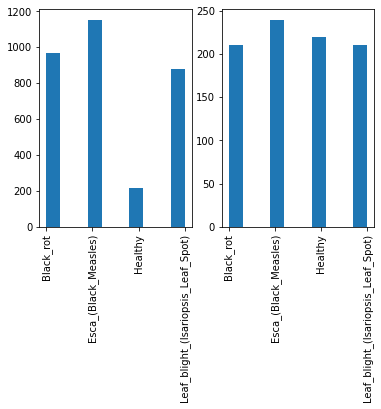

In [5]:
import matplotlib.pyplot as plt

print("Train image size")
print(x_train.shape)
print("Test image size")
print(x_test.shape)

fig, axs = plt.subplots(1, 2)
axs[0].hist(y_train)
for tick in axs[0].get_xticklabels():
    tick.set_rotation(90)

axs[1].hist(y_test)
for tick in axs[1].get_xticklabels():
    tick.set_rotation(90)

plt.show()

In [6]:
from sklearn.preprocessing import OneHotEncoder

y_train_ = [[y] for y in y_train]
y_test_ = [[y] for y in y_test]

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_train_)

categories = enc.categories_[0]
print(categories)

y_train_onehot = enc.transform(y_train_).toarray()
y_test_onehot = enc.transform(y_test_).toarray()

print("Shape of y_train_onehot")
print(y_train_onehot.shape)
print("Shape of y_test_onehot")
print(y_test_onehot.shape)

['Black_rot' 'Esca_(Black_Measles)' 'Healthy'
 'Leaf_blight_(Isariopsis_Leaf_Spot)']
Shape of y_train_onehot
(3209, 4)
Shape of y_test_onehot
(880, 4)


In [54]:
from keras import layers
from keras import Sequential

INP_SHAPE = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
print(INP_SHAPE)
CLASS_SIZE = len(categories)

def lenet(act_func='sigmoid'):
    model = Sequential(name='lenet')
    model.add(layers.Conv2D(6, (5,5), padding='same', input_shape=INP_SHAPE, activation=act_func))
    model.add(layers.AveragePooling2D(pool_size=(2,2)))
    model.add(layers.Conv2D(16, (5,5), padding='valid', activation=act_func))
    model.add(layers.AveragePooling2D(pool_size=(2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation=act_func))
    model.add(layers.Dense(84, activation=act_func))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(CLASS_SIZE, activation='softmax'))

    return model

(128, 128, 3)


In [50]:
from keras import optimizers

opt = optimizers.Adam(learning_rate=0.001)
model = lenet()
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [17]:
model.summary()

Model: "lenet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 6)       456       
                                                                 
 average_pooling2d_4 (Averag  (None, 64, 64, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        2416      
                                                                 
 average_pooling2d_5 (Averag  (None, 30, 30, 16)       0         
 ePooling2D)                                                     
                                                                 
 flatten_2 (Flatten)         (None, 14400)             0         
                                                                 
 dense_6 (Dense)             (None, 120)               172812

In [51]:
train_hist = model.fit(x_train, y_train_onehot, batch_size=16,
                        epochs=5, verbose=1, validation_split=0.15, shuffle=True)

Epoch 1/5
171/171 [==============================] - 16s 93ms/step - loss: 1.2245 - accuracy: 0.4041 - val_loss: 1.8755 - val_accuracy: 0.0000e+00
Epoch 2/5
 92/171 [===============>..............] - ETA: 7s - loss: 1.2296 - accuracy: 0.3967

KeyboardInterrupt: 

In [20]:
loss, acc = model.evaluate(x_test, y_test_onehot, verbose = 1)
print("Model's accuracy: {:5.2f}%".format(100*acc))

28/28 [==============================] - 1s 52ms/step - loss: 1.5853 - accuracy: 0.2727
Model's accuracy: 27.27%


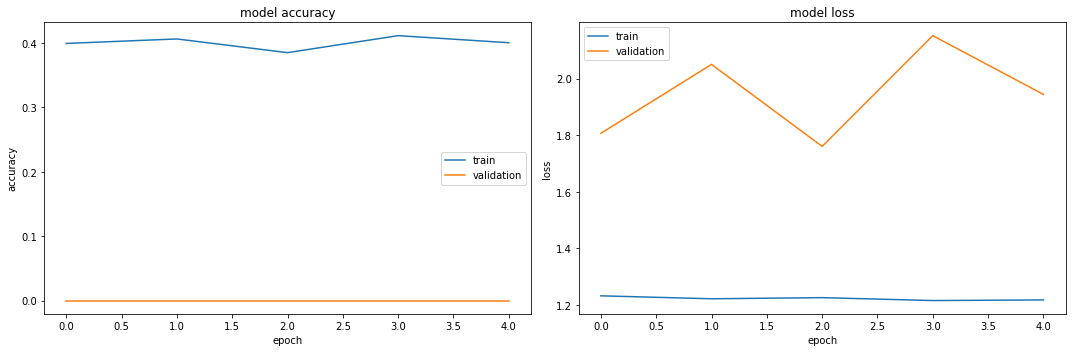

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(train_hist.history['accuracy'])
axs[0].plot(train_hist.history['val_accuracy'])
axs[0].set_title('model accuracy')
axs[0].set_ylabel('accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'validation'])

axs[1].plot(train_hist.history['loss'])
axs[1].plot(train_hist.history['val_loss'])
axs[1].set_title('model loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'validation'])

plt.tight_layout()
plt.show()

In [60]:
def train(model, opt):
    print("Start training %s" % (model.name))
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    train_hist = model.fit(x_train, y_train_onehot, batch_size=4,
                        epochs=10, validation_data=(x_test, y_test_onehot)
                        , verbose=1, shuffle=True)
                        # , validation_split=0.15
    loss, acc = model.evaluate(x_test, y_test_onehot, verbose = 1)
    print("Model's accuracy: {:5.2f}%".format(100*acc))

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    axs[0].plot(train_hist.history['accuracy'])
    axs[0].plot(train_hist.history['val_accuracy'])
    axs[0].set_title('model accuracy')
    axs[0].set_ylabel('accuracy')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'validation'])

    axs[1].plot(train_hist.history['loss'])
    axs[1].plot(train_hist.history['val_loss'])
    axs[1].set_title('model loss')
    axs[1].set_ylabel('loss')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'validation'])

    plt.tight_layout()
    plt.show()

In [61]:
model = lenet(act_func='relu')
opt = optimizers.Adam(learning_rate=0.0001)

train(model, opt)

Start training lenet
Epoch 1/10
803/803 [==============================] - 30s 37ms/step - loss: 1.0404 - accuracy: 0.5659 - val_loss: 0.7318 - val_accuracy: 0.6886
Epoch 2/10
803/803 [==============================] - 34s 43ms/step - loss: 0.5138 - accuracy: 0.7753 - val_loss: 0.4942 - val_accuracy: 0.8091
Epoch 3/10
803/803 [==============================] - 33s 42ms/step - loss: 0.2874 - accuracy: 0.8825 - val_loss: 0.2679 - val_accuracy: 0.8932
Epoch 4/10
803/803 [==============================] - 33s 41ms/step - loss: 0.1656 - accuracy: 0.9405 - val_loss: 0.3066 - val_accuracy: 0.8898
Epoch 5/10
803/803 [==============================] - 33s 42ms/step - loss: 0.1133 - accuracy: 0.9570 - val_loss: 0.3077 - val_accuracy: 0.9125
Epoch 6/10
230/803 [=======>......................] - ETA: 22s - loss: 0.0769 - accuracy: 0.9685

KeyboardInterrupt: 

1/1 [==============================] - 0s 25ms/step
[[9.9999762e-01 2.2486106e-06 3.7678212e-09 1.2835366e-07]]
Prediction: Black_rot


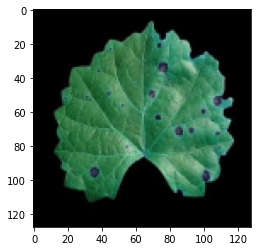

In [28]:
import cv2 as cv

img_path = './grape_leaf_disease_detection/image_data/test/Black_rot/1a6aabd0-7ca8-4074-a457-5a8f3662a7d7___FAM_B.Rot 3539_final_masked.jpg'

img = cv.imread(img_path)
if NEW_SIZE != IMG_ROW or NEW_SIZE != IMG_COL:
    img = cv.resize(img, (NEW_SIZE,NEW_SIZE))

out = model.predict(img[np.newaxis, :, :, :])[0]

print(out)

pred = categories[np.argmax(out)]
print("Prediction: " + pred)
plt.imshow(img)
plt.show()

In [42]:
def alexnet():
    model = Sequential(name='alexnet')
    model.add(layers.Conv2D(96, (3,3), padding='same', strides=(3,3), input_shape=INP_SHAPE, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
    model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(CLASS_SIZE, activation='softmax'))

    return model

In [43]:
model = alexnet()
model.summary()

Model: "alexnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 43, 43, 96)        2688      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 21, 21, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 21, 21, 128)       110720    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 10, 10, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 10, 10, 128)       147584    
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 4, 4, 128)        0   

Start training alexnet
Epoch 1/10
171/171 [==============================] - 34s 194ms/step - loss: 4.0185 - accuracy: 0.5207 - val_loss: 0.3401 - val_accuracy: 0.8797
Epoch 2/10
171/171 [==============================] - 36s 210ms/step - loss: 0.7440 - accuracy: 0.6571 - val_loss: 1.4322 - val_accuracy: 0.5809
Epoch 3/10
171/171 [==============================] - 34s 199ms/step - loss: 0.5012 - accuracy: 0.7759 - val_loss: 0.3716 - val_accuracy: 0.8755
Epoch 4/10
171/171 [==============================] - 34s 197ms/step - loss: 0.4144 - accuracy: 0.8368 - val_loss: 0.2820 - val_accuracy: 0.9170
Epoch 5/10
171/171 [==============================] - 34s 199ms/step - loss: 0.3570 - accuracy: 0.8687 - val_loss: 0.4251 - val_accuracy: 0.8589
Epoch 6/10
171/171 [==============================] - 34s 197ms/step - loss: 0.3409 - accuracy: 0.8775 - val_loss: 0.2366 - val_accuracy: 0.9274
Epoch 7/10
171/171 [==============================] - 34s 196ms/step - loss: 0.2866 - accuracy: 0.8966 - va

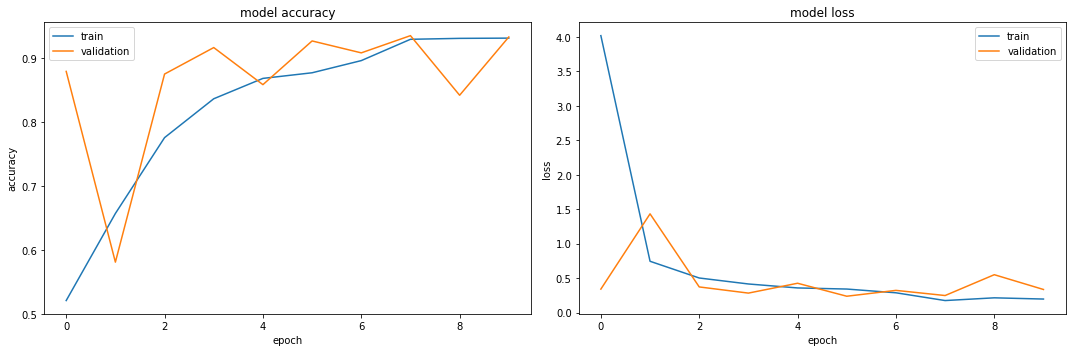

In [33]:
opt = optimizers.Adam(learning_rate=0.001)
train(model, opt)

1/1 [==============================] - 0s 89ms/step
[0.96268654 0.00525149 0.02826526 0.00379675]
Prediction: Black_rot


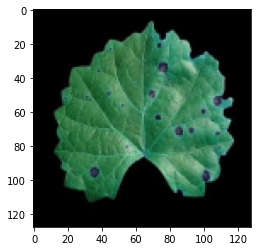

In [34]:
img_path = './grape_leaf_disease_detection/image_data/test/Black_rot/1a6aabd0-7ca8-4074-a457-5a8f3662a7d7___FAM_B.Rot 3539_final_masked.jpg'

img = cv.imread(img_path)
if NEW_SIZE != IMG_ROW or NEW_SIZE != IMG_COL:
    img = cv.resize(img, (NEW_SIZE,NEW_SIZE))

out = model.predict(img[np.newaxis, :, :, :])[0]

print(out)

pred = categories[np.argmax(out)]
print("Prediction: " + pred)
plt.imshow(img)
plt.show()

In [44]:
def xunyiznet():
    model = Sequential(name="xunyiznet")
    model.add(layers.Conv2D(32, (3,3), padding='same', input_shape=INP_SHAPE, activation='relu'))
    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(8,8)))
    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(8,8)))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(CLASS_SIZE, activation='softmax'))

    return model


In [45]:
model = xunyiznet()
model.summary()

Model: "xunyiznet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 conv2d_31 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 conv2d_33 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 2, 2, 32)         0         
 g2D)                                                    

Start training xunyiznet
Epoch 1/10
171/171 [==============================] - 42s 242ms/step - loss: 1.0640 - accuracy: 0.6183 - val_loss: 0.2043 - val_accuracy: 0.9295
Epoch 2/10
171/171 [==============================] - 47s 272ms/step - loss: 0.3045 - accuracy: 0.8801 - val_loss: 0.1672 - val_accuracy: 0.9419
Epoch 3/10
171/171 [==============================] - 44s 257ms/step - loss: 0.1962 - accuracy: 0.9234 - val_loss: 0.1982 - val_accuracy: 0.9232
Epoch 4/10
171/171 [==============================] - 45s 261ms/step - loss: 0.1509 - accuracy: 0.9432 - val_loss: 0.0634 - val_accuracy: 0.9772
Epoch 5/10
171/171 [==============================] - 44s 258ms/step - loss: 0.0976 - accuracy: 0.9655 - val_loss: 0.3248 - val_accuracy: 0.8963
Epoch 6/10
171/171 [==============================] - 48s 278ms/step - loss: 0.0624 - accuracy: 0.9824 - val_loss: 0.0314 - val_accuracy: 0.9896
Epoch 7/10
171/171 [==============================] - 45s 264ms/step - loss: 0.1080 - accuracy: 0.9630 - 

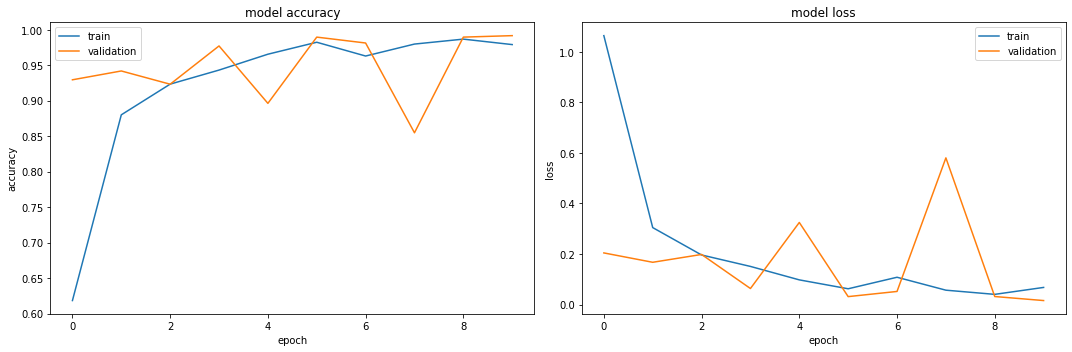

In [46]:
opt = optimizers.Adam(learning_rate=0.001)
train(model, opt)